In [ ]:
!pip install datasets
!pip install transformers==4.39.1
!pip install flash-attn
!pip install accelerate
!pip install bitsandbytes==0.41.0
!pip install auto-gptq
!pip install accelerate

In [ ]:
!nvidia-smi

Tue May  7 23:06:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# FLASH ATTENTION 2

### Dataset import, benckmark code

In [ ]:
import torch
import os
import argparse
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [ ]:
dataset = load_dataset("microsoft/LCC_python")
test_dataset = dataset["test"]
l = []
for data in test_dataset:
      l.append([len(data['context']),data['gt'],data['context']])
l.sort()

model_id = "bigcode/starcoder2-7b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

#### Selecting 1024 context window
prompts = []
input_ids = []
for i in range(1024):
    prompt = "".join(l[i][2][:1024])
    input_id = tokenizer.encode(prompt, padding=True)
    input_ids.append(input_id)

# Define the padding token
pad_token = tokenizer.convert_tokens_to_ids(tokenizer.eos_token)
input_ids = [torch.tensor(seq[::-1]) for seq in input_ids]

# Pad the input sequences
input_ids = pad_sequence(input_ids, batch_first=True, padding_value=pad_token).flip(dims=[1])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.88k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

In [ ]:
@torch.no_grad()
def warmup_and_benchmark(
    model,
    use_padding,
    bench_generate,
    max_new_tokens,
    input_ids = None,
    context_length = 4096
):
    input_ids = torch.randint(0, model.config.vocab_size, (batch_size, context_length)).to(0)
    inputs = {"input_ids": input_ids}

    with torch.no_grad():
        for _ in range(2):
            _ = model.generate(**inputs, max_new_tokens=20, pad_token_id=tokenizer.eos_token_id, use_cache=False)

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    forward_total_time = 0.0

    with torch.no_grad():
        for _ in range(4):
            torch.cuda.empty_cache()
            start_event.record()
            if bench_generate:
                _ = model.generate(**inputs, max_new_tokens=max_new_tokens, pad_token_id=tokenizer.eos_token_id, use_cache=False)
            else:
                _ = model(input_ids)
            end_event.record()
            torch.cuda.synchronize()
            forward_total_time += start_event.elapsed_time(end_event) * 1.0e-3


    forward_timing = (forward_total_time) / 4
    backward_timing = 0

    return forward_timing, 0

In [ ]:
bench_generate = True
use_padding = True
max_new_tokens = 16

### Starcoder2 using fp32 (without Flash Attention 2)

In [ ]:
# Default Starcoder using fp32

model = AutoModelForCausalLM.from_pretrained(
        model_id
    ).to(0)

print("native", model)

config.json:   0%|          | 0.00/893 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.51G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

native Starcoder2ForCausalLM(
  (model): Starcoder2Model(
    (embed_tokens): Embedding(49152, 4608)
    (layers): ModuleList(
      (0-31): 32 x Starcoder2DecoderLayer(
        (self_attn): Starcoder2SdpaAttention(
          (q_proj): Linear(in_features=4608, out_features=4608, bias=True)
          (k_proj): Linear(in_features=4608, out_features=512, bias=True)
          (v_proj): Linear(in_features=4608, out_features=512, bias=True)
          (o_proj): Linear(in_features=4608, out_features=4608, bias=True)
          (rotary_emb): Starcoder2RotaryEmbedding()
        )
        (mlp): Starcoder2MLP(
          (c_fc): Linear(in_features=4608, out_features=18432, bias=True)
          (c_proj): Linear(in_features=18432, out_features=4608, bias=True)
          (act): PytorchGELUTanh()
        )
        (input_layernorm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
      )
    )
    (norm): 

In [ ]:
native_total_time_dict = {}
context_length = 4096
BATCH_SIZE = [2, 4]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        native_timing, native_backward_timing = warmup_and_benchmark(
                model,
                use_padding,
                bench_generate,
                max_new_tokens,
                input_ids[:batch_size,:].to(0),
                context_length
            )
        native_total_time_dict[f"{batch_size}"] += native_timing/4

print(native_total_time_dict)  # Native fp32 4096 context

{'2': 29.02031640625}


In [ ]:
print(native_total_time_dict) # Native fp32 4096 context

{'4': 58.0192890625}


In [ ]:
model = model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

### Starcoder2 using bf16 (without Flash Attention 2)

In [ ]:
# Default Starcoder using bf16

model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16
    ).to(0)

print("native", model)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

native Starcoder2ForCausalLM(
  (model): Starcoder2Model(
    (embed_tokens): Embedding(49152, 4608)
    (layers): ModuleList(
      (0-31): 32 x Starcoder2DecoderLayer(
        (self_attn): Starcoder2SdpaAttention(
          (q_proj): Linear(in_features=4608, out_features=4608, bias=True)
          (k_proj): Linear(in_features=4608, out_features=512, bias=True)
          (v_proj): Linear(in_features=4608, out_features=512, bias=True)
          (o_proj): Linear(in_features=4608, out_features=4608, bias=True)
          (rotary_emb): Starcoder2RotaryEmbedding()
        )
        (mlp): Starcoder2MLP(
          (c_fc): Linear(in_features=4608, out_features=18432, bias=True)
          (c_proj): Linear(in_features=18432, out_features=4608, bias=True)
          (act): PytorchGELUTanh()
        )
        (input_layernorm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
      )
    )
    (norm): 

In [ ]:
context_length = 4096
native_total_time_dict = {}
BATCH_SIZE = [2, 4, 8]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        native_timing, native_backward_timing = warmup_and_benchmark(
                model,
                use_padding,
                bench_generate,
                max_new_tokens,
                input_ids[:batch_size,:].to(0),
                context_length
            )
        native_total_time_dict[f"{batch_size}"] += native_timing/4

print(native_total_time_dict)  # Native bf16 4096 context

In [ ]:
context_length = 8192
native_total_time_dict = {}
BATCH_SIZE = [2, 4]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        native_timing, native_backward_timing = warmup_and_benchmark(
                model,
                use_padding,
                bench_generate,
                max_new_tokens,
                input_ids[:batch_size,:].to(0),
                context_length
            )
        native_total_time_dict[f"{batch_size}"] += native_timing/4

print(native_total_time_dict)  # Native bf16 8192 context

{'2': 5.204810546875, '4': 16.7480546875}


In [ ]:
print(native_total_time_dict)  # Native bf16 8192 context

{'2': 5.18952392578125, '4': 16.748796875}


In [ ]:
context_length = 16384
native_total_time_dict = {}
BATCH_SIZE = [2]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        native_timing, native_backward_timing = warmup_and_benchmark(
                model,
                use_padding,
                bench_generate,
                max_new_tokens,
                input_ids[:batch_size,:].to(0),
                context_length
            )
        native_total_time_dict[f"{batch_size}"] += native_timing/4

print(native_total_time_dict)  # Native bf16 16384 context

{'2': 12.2653115234375}


In [ ]:
context_length = 18000
native_total_time_dict = {}
BATCH_SIZE = [2]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        native_timing, native_backward_timing = warmup_and_benchmark(
                model,
                use_padding,
                bench_generate,
                max_new_tokens,
                input_ids[:batch_size,:].to(0),
                context_length
            )
        native_total_time_dict[f"{batch_size}"] += native_timing/4

print(native_total_time_dict)  # Native bf16 18000 context

{'2': 13.7993896484375}


In [ ]:
model = model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

Starcoder flash attention is not implemented with fp32 in huggingface

### Starcoder2 using bf16 (with Flash Attention 2)

In [ ]:
# Flash Attention Starcoder using bf16

model_fa = AutoModelForCausalLM.from_pretrained(
        "bigcode/starcoder2-7b",
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2"
    ).to(0)
model_fa.to('cuda')

print("FA2", model_fa)

In [ ]:
context_length = 4096
fa2_total_time_dict = {}
BATCH_SIZE = [2, 4, 8]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        fa2_timing, fa2_backward_timing = warmup_and_benchmark(
                model_fa,
                use_padding,
                bench_generate,
                max_new_tokens,
                input_ids[:batch_size,:].to(0),
                context_length
        )
        fa2_total_time_dict[f"{batch_size}"] += fa2_timing/4

print(fa2_total_time_dict) # Flash attention bf16 4096 context

In [ ]:
context_length = 8192
fa2_total_time_dict = {}
BATCH_SIZE = [2, 4]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        fa2_timing, fa2_backward_timing = warmup_and_benchmark(
                model_fa,
                use_padding,
                bench_generate,
                max_new_tokens,
                input_ids[:batch_size,:].to(0),
                context_length
        )
        fa2_total_time_dict[f"{batch_size}"] += fa2_timing/4

print(fa2_total_time_dict) # Flash attention fp16 8192 context

{'2': 5.41222021484375, '4': 10.3216201171875}


In [ ]:
context_length = 16384
fa2_total_time_dict = {}
BATCH_SIZE = [2]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        fa2_timing, fa2_backward_timing = warmup_and_benchmark(
                model_fa,
                use_padding,
                bench_generate,
                max_new_tokens,
                input_ids[:batch_size,:].to(0),
                context_length
        )
        fa2_total_time_dict[f"{batch_size}"] += fa2_timing/4

print(fa2_total_time_dict) # Flash attention fp16 16384 context

{'2': 10.9564326171875}


In [ ]:
context_length = 18000
fa2_total_time_dict = {}
BATCH_SIZE = [2, 4]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        fa2_timing, fa2_backward_timing = warmup_and_benchmark(
                model_fa,
                use_padding,
                bench_generate,
                max_new_tokens,
                input_ids[:batch_size,:].to(0),
                context_length
        )
        fa2_total_time_dict[f"{batch_size}"] += fa2_timing/4

print(fa2_total_time_dict) # Flash attention fp16 18000 context

{'2': 11.311974609375}


In [ ]:
model_fa = model_fa.cpu()
del model_fa
gc.collect()
torch.cuda.empty_cache()

### Graphs for Comparing Normal Attention vs Flash Attention

In [ ]:
native_total_time_dict = {'4': 6.42793017578125, '8': 13.330107421875}
fa2_total_time_dict = {'4': 4.91732421875, '8': 10.017291015625}

forward_speedups = {}
backward_speedups = {}
for batch_size in ['4','8']:
    native_total_time_dict[f"{batch_size}"] = native_total_time_dict[f"{batch_size}"] * 4
    fa2_total_time_dict[f"{batch_size}"] = fa2_total_time_dict[f"{batch_size}"] * 4
    forward_speedups[f"{batch_size}"] = native_total_time_dict[f"{batch_size}"]/fa2_total_time_dict[f"{batch_size}"]
    backward_speedups[f"{batch_size}"] = 0

In [ ]:
  for batch_size in tqdm(BATCH_SIZE):
    forward_speedups[f"{batch_size}"] = native_total_time_dict[f"{batch_size}"]/fa2_total_time_dict[f"{batch_size}"]
    backward_speedups[f"{batch_size}"] = 0

100%|██████████| 3/3 [00:00<00:00, 24720.85it/s]


In [ ]:
model_id='starcoder2-7b'
bench_generate=True

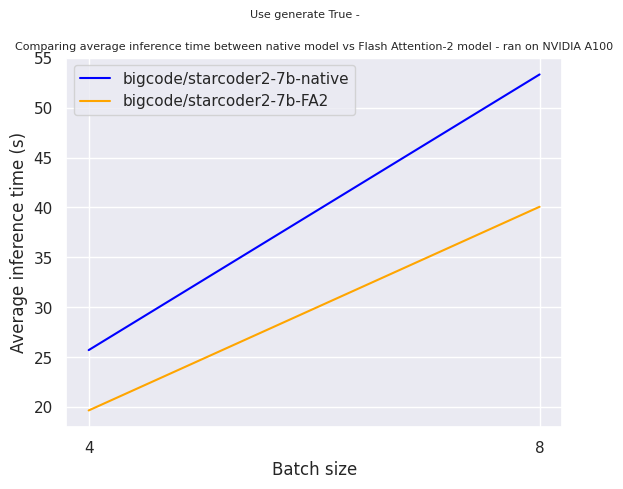

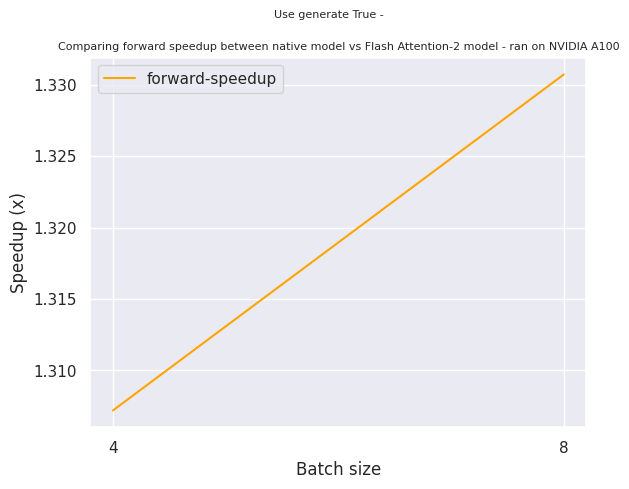

In [ ]:
# dir_name = f"flash-attn-2-benchmarks/{model_id}/padding_1_generate_{bench_generate}_max_batch_size_{max_batch_size}/"
import torch
import os
import argparse
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
import seaborn as sns
dir_name ='c'

os.makedirs(dir_name, exist_ok=True)

sns.set(style="darkgrid")
sns.lineplot(data=native_total_time_dict, color="blue", label=f"{model_id}-native")
sns.lineplot(data=fa2_total_time_dict, color="orange", label=f"{model_id}-FA2")

plt.ylabel("Average inference time (s)")
plt.xlabel("Batch size")
plt.title("Comparing average inference time between native model vs Flash Attention-2 model - ran on NVIDIA A100", fontsize = 8)
plt.suptitle(f"Use generate {bench_generate} - ", fontsize = 8)
plt.legend()

# save plot
plt.savefig(os.path.join(dir_name, "timing_plot.jpg"), dpi=300)
plt.figure()
sns.set(style="darkgrid")
# plot both lines
sns.lineplot(data=forward_speedups, color="orange", label="forward-speedup")
    # if bench_backward:
    #     sns.lineplot(data=backward_speedups, color="blue", label="backward-speedup")

plt.ylabel("Speedup (x)")
plt.xlabel("Batch size")
plt.title("Comparing forward speedup between native model vs Flash Attention-2 model - ran on NVIDIA A100", fontsize = 8)
plt.suptitle(f"Use generate {bench_generate} - ", fontsize = 8)

plt.legend()
# save plot
plt.savefig(os.path.join(dir_name, "speedup_plot.jpg"), dpi=300)

# Quantization

### Dataset import and perplexity code

In [ ]:
dataset = load_dataset("flytech/python-codes-25k")
perplexity_dataset = dataset["train"].select(range(512))

In [ ]:
def perplexity(test, tokenizer, model, device):
    encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")
    max_length = tokenizer.model_max_length
    stride = 512
    seq_len = encodings.input_ids.size(1)
    model.eval()

    lls = []
    for i in tqdm(range(0, seq_len, stride)):
        begin_loc = max(i + stride - max_length, 0)
        end_loc = min(i + stride, encodings.input_ids.size(1))
        trg_len = end_loc - i
        input_ids = encodings.input_ids[:,begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:,:-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids, use_cache=False)
            log_likelihood = outputs[0] * trg_len

        lls.append(log_likelihood)
        del input_ids, target_ids, outputs
        gc.collect()
        torch.cuda.empty_cache()

    ppl = torch.exp(torch.stack(lls).sum() / end_loc)
    return ppl

model_id = "bigcode/starcoder2-7b"
tokenizer = AutoTokenizer.from_pretrained(model_id)

### Perplexity of Starcoder2 with bf16 (With Flash Attention)

In [ ]:
vanilla_model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2"
    ).to(0)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
ppl = perplexity(perplexity_dataset,tokenizer,vanilla_model,"cuda")
print(ppl) # Flash Attention with fp16

tensor(1.7017, device='cuda:0')


In [ ]:
vanilla_model = vanilla_model.cpu()
del vanilla_model
gc.collect()
torch.cuda.empty_cache()

### Perplexity and benckmark of Starcoder2 with fp8 using Bits And Bytes (With Flash Attention)

In [ ]:
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

quantized_model = AutoModelForCausalLM.from_pretrained(
          model_id,
          quantization_config=quantization_config,
          attn_implementation="flash_attention_2"
      ).to(0)

print("8-bit qunatized model: ", quantized_model)

8-bit qunatized model:  Starcoder2ForCausalLM(
  (model): Starcoder2Model(
    (embed_tokens): Embedding(49152, 4608)
    (layers): ModuleList(
      (0-31): 32 x Starcoder2DecoderLayer(
        (self_attn): Starcoder2FlashAttention2(
          (q_proj): Linear8bitLt(in_features=4608, out_features=4608, bias=True)
          (k_proj): Linear8bitLt(in_features=4608, out_features=512, bias=True)
          (v_proj): Linear8bitLt(in_features=4608, out_features=512, bias=True)
          (o_proj): Linear8bitLt(in_features=4608, out_features=4608, bias=True)
          (rotary_emb): Starcoder2RotaryEmbedding()
        )
        (mlp): Starcoder2MLP(
          (c_fc): Linear8bitLt(in_features=4608, out_features=18432, bias=True)
          (c_proj): Linear8bitLt(in_features=18432, out_features=4608, bias=True)
          (act): PytorchGELUTanh()
        )
        (input_layernorm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4608,), eps=1e-

In [ ]:
context_length = 4096
eight_total_time_dict={}
BATCH_SIZE = [2, 4, 8]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        eight_timing, eight_backward_timing = warmup_and_benchmark(
                  quantized_model,
                  use_padding,
                  bench_generate,
                  max_new_tokens
        )
        eight_total_time_dict[f"{batch_size}"] += eight_timing/4

print(eight_total_time_dict)  # with fp8 weights, fp32 compute, 4096 context

{'2': 3.3211618652343753, '4': 6.911981445312501, '8': 14.499599609375}


In [ ]:
eight_bit_ppl = perplexity(perplexity_dataset,tokenizer,quantized_model,"cuda")
print(eight_bit_ppl)

tensor(1.7048, device='cuda:0')


In [ ]:
quantized_model = quantized_model.cpu()
del quantized_model
gc.collect()
torch.cuda.empty_cache()

### Perplexity and benckmark of Starcoder2 with nf4 and fp16 compute using Bits And Bytes (With Flash Attention)

In [ ]:
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

quantized_model = AutoModelForCausalLM.from_pretrained(
          model_id,
          quantization_config=nf4_config,
          attn_implementation="flash_attention_2"
      ).to(0)

print("4bit quantized model", quantized_model)

4bit quantized model Starcoder2ForCausalLM(
  (model): Starcoder2Model(
    (embed_tokens): Embedding(49152, 4608)
    (layers): ModuleList(
      (0-31): 32 x Starcoder2DecoderLayer(
        (self_attn): Starcoder2FlashAttention2(
          (q_proj): Linear4bit(in_features=4608, out_features=4608, bias=True)
          (k_proj): Linear4bit(in_features=4608, out_features=512, bias=True)
          (v_proj): Linear4bit(in_features=4608, out_features=512, bias=True)
          (o_proj): Linear4bit(in_features=4608, out_features=4608, bias=True)
          (rotary_emb): Starcoder2RotaryEmbedding()
        )
        (mlp): Starcoder2MLP(
          (c_fc): Linear4bit(in_features=4608, out_features=18432, bias=True)
          (c_proj): Linear4bit(in_features=18432, out_features=4608, bias=True)
          (act): PytorchGELUTanh()
        )
        (input_layernorm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4608,), eps=1e-05, elementwise

In [ ]:
context_length = 4096
four_total_time_dict={}
BATCH_SIZE = [2, 4, 8]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        four_timing, four_backward_timing = warmup_and_benchmark(
                  quantized_model,
                  use_padding,
                  bench_generate,
                  max_new_tokens,
        )
        four_total_time_dict[f"{batch_size}"] += four_timing/4

print(four_total_time_dict) # with nf4 weights, fp16 compute, 4096 context

{'2': 3.329209228515625, '4': 7.0678867187500005, '8': 13.9194580078125}


In [ ]:
four_bit_ppl = perplexity(perplexity_dataset,tokenizer,quantized_model,"cuda")
print(four_bit_ppl)

tensor(1.7139, device='cuda:0')


In [ ]:
quantized_model = quantized_model.cpu()
del quantized_model
gc.collect()
torch.cuda.empty_cache()

### Perplexity and benckmark of Starcoder2 with nf4 and fp32 compute using Bits And Bytes (With Flash Attention)

In [ ]:
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
)

quantized_model = AutoModelForCausalLM.from_pretrained(
          model_id,
          quantization_config=nf4_config,
          attn_implementation="flash_attention_2"
      ).to(0)

print("4bit quantized model", quantized_model)

In [ ]:
context_length = 4096
four_total_time_dict={}
BATCH_SIZE = [2, 4, 8]

for i in range(4):
    for batch_size in tqdm(BATCH_SIZE):
        four_timing, four_backward_timing = warmup_and_benchmark(
                  quantized_model,
                  use_padding,
                  bench_generate,
                  max_new_tokens,
        )
        four_total_time_dict[f"{batch_size}"] += four_timing/4

print(four_total_time_dict) # with nf4 weights, fp32 compute, 4096 context

{'2': 25.39214453125, '4': 50.7089609375, '8': 100.29119531250001}


In [ ]:
print(f"Memory footprint: {quantized_model.get_memory_footprint() / 1e6:.2f} MB")

Memory footprint: 7670.52 MB


In [ ]:
quantized_model = quantized_model.cpu()
del quantized_model
gc.collect()
torch.cuda.empty_cache()

### Graphs

### HumanEval dataset evaluation

In [ ]:
!git clone https://github.com/bigcode-project/bigcode-evaluation-harness.git

Cloning into 'bigcode-evaluation-harness'...
remote: Enumerating objects: 4135, done.
remote: Counting objects: 100% (1612/1612), done.
remote: Compressing objects: 100% (497/497), done.
remote: Total 4135 (delta 1273), reused 1301 (delta 1106), pack-reused 2523
Receiving objects: 100% (4135/4135), 825.34 KiB | 7.50 MiB/s, done.
Resolving deltas: 100% (2812/2812), done.


In [ ]:
cd bigcode-evaluation-harness

/content/bigcode-evaluation-harness


In [ ]:
!pip install -e .
!pip install git-lfs
!git config --global credential.helper store

Obtaining file:///content/bigcode-evaluation-harness
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyext: filename=pyext-0.7-py3-none-any.whl size=7222 sha256=4bc4eac3f91b05337ee2cf96aa86dbc90037881c2f5c5e360b0d234c338d74da
  Stored in directory: /root/.cache/pip/wheels/09/95/a9/f3f15c5e52dec7912c332ae503e82fd680e576bf336437f002
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=35b3b070b2a5785497633b47f9472402ae41c15b2a75ce4c40615c2ac4f7d831
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for toolwrapper: filename=toolwrapper-2.1.0-py3-none-any.whl size=3336 sha256=7a4338b1f1ac73c5

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!accelerate launch main.py \
    --model bigcode/starcoder2-7b \
    --tasks humaneval \
    --allow_code_execution \
    --save_generations \
    --precision fp16 \
    --batch_size 10

In [ ]:
!accelerate launch main.py \
    --model bigcode/starcoder2-7b \
    --tasks humaneval \
    --allow_code_execution \
    --save_generations \
    --precision fp16 \
    --load_in_8bit\
    --batch_size 10

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-05-07 23:15:50.224159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 23:15:50.224208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 23:15:50.225977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

In [ ]:
!accelerate launch main.py \
    --model bigcode/starcoder2-7b \
    --tasks humaneval \
    --allow_code_execution \
    --save_generations \
    --precision fp16 \
    --load_in_4bit\
    --batch_size 40

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2024-05-08 00:41:37.460824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 00:41:37.460878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 00:41:37.462663: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

In [ ]:
torch.cuda.empty_cache()

### Using GPTQ

In [ ]:
!pip install git+https://github.com/huggingface/optimum.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install --upgrade accelerate

In [ ]:
from datasets import load_dataset

dataset = load_dataset("flytech/python-codes-25k")
perplexity_dataset = dataset["train"].select(range(0,512))

In [ ]:
calibration_dataset = dataset["train"].select(range(128))["text"]

In [ ]:
print(calibration_dataset[1])

Create a shopping list based on my inputs! Creating a shopping list... ```python
shopping_list = {}
while True:
    item = input('Enter an item or type 'done' to finish: ')
    if item == 'done': break
    quantity = input(f'Enter the quantity for {item}: ')
    shopping_list[item] = quantity
print(f'Your shopping list: {shopping_list}')
```


In [ ]:
# pip install bitsandbytes accelerate
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig
tokenizer = AutoTokenizer.from_pretrained(model_id)

gptq_config = GPTQConfig(bits=8,group_size=128,  # it is recommended to set the value to 128
    desc_act=False, dataset=calibration_dataset, tokenizer=tokenizer)

model_id = "bigcode/starcoder2-7b"
quantized_model = AutoModelForCausalLM.from_pretrained(model_id,torch_dtype=torch.bfloat16,  device_map="auto", quantization_config=gptq_config,attn_implementation="flash_attention_2")

In [ ]:
print(quantized_model)

Starcoder2ForCausalLM(
  (model): Starcoder2Model(
    (embed_tokens): Embedding(49152, 4608)
    (layers): ModuleList(
      (0-31): 32 x Starcoder2DecoderLayer(
        (self_attn): Starcoder2FlashAttention2(
          (rotary_emb): Starcoder2RotaryEmbedding()
          (k_proj): QuantLinear()
          (o_proj): QuantLinear()
          (q_proj): QuantLinear()
          (v_proj): QuantLinear()
        )
        (mlp): Starcoder2MLP(
          (act): PytorchGELUTanh()
          (c_fc): QuantLinear()
          (c_proj): QuantLinear()
        )
        (input_layernorm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
      )
    )
    (norm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=4608, out_features=49152, bias=False)
)


In [ ]:
perplexity_dataset = dataset["train"].select(range(512))

In [ ]:
eight_bit_ppl = perplexity(perplexity_dataset,tokenizer,quantized_model,"cuda")

  0%|          | 0/88 [00:04<?, ?it/s]


In [ ]:
print(eight_bit_ppl)

tensor(1.7225, device='cuda:0')


In [ ]:
eight_total_time_dict = {}

In [ ]:
for batch_size in tqdm(BATCH_SIZE):
  eight_timing, eight_backward_timing = warmup_and_benchmark(
            quantized_model,
            use_padding,
            bench_generate,
            max_new_tokens,
            input_ids[:batch_size,:].to(0)
  )
  eight_total_time_dict[f"{batch_size}"] = eight_timing

In [ ]:
print(eight_total_time_dict)

{'4': 5.63950537109375, '8': 10.775910156250001}


In [ ]:
# pip install bitsandbytes accelerate
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig
tokenizer = AutoTokenizer.from_pretrained(model_id)

gptq_config = GPTQConfig(bits=4,group_size=128,  # it is recommended to set the value to 128
    desc_act=False, dataset=calibration_dataset, tokenizer=tokenizer)

model_id = "bigcode/starcoder2-7b"
quantized_model = AutoModelForCausalLM.from_pretrained(model_id,  device_map="auto", quantization_config=gptq_config,attn_implementation="flash_attention_2")

In [ ]:
print(quantized_model)

Starcoder2ForCausalLM(
  (model): Starcoder2Model(
    (embed_tokens): Embedding(49152, 4608)
    (layers): ModuleList(
      (0-31): 32 x Starcoder2DecoderLayer(
        (self_attn): Starcoder2FlashAttention2(
          (rotary_emb): Starcoder2RotaryEmbedding()
          (k_proj): QuantLinear()
          (o_proj): QuantLinear()
          (q_proj): QuantLinear()
          (v_proj): QuantLinear()
        )
        (mlp): Starcoder2MLP(
          (act): PytorchGELUTanh()
          (c_fc): QuantLinear()
          (c_proj): QuantLinear()
        )
        (input_layernorm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
      )
    )
    (norm): LayerNorm((4608,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=4608, out_features=49152, bias=False)
)


In [ ]:
perplexity_dataset = dataset["train"].select(range(512))

In [ ]:
four_bit_ppl = perplexity(perplexity_dataset,tokenizer,quantized_model,"cuda")

  0%|          | 0/88 [00:03<?, ?it/s]


In [ ]:
print(four_bit_ppl)

tensor(1.7096, device='cuda:0')


In [ ]:
four_total_time_dict = {}

In [ ]:
for batch_size in tqdm(BATCH_SIZE):
  four_timing, four_backward_timing = warmup_and_benchmark(
            quantized_model,
            use_padding,
            bench_generate,
            max_new_tokens,
            input_ids[:batch_size,:].to(0)
  )
  four_total_time_dict[f"{batch_size}"] = four_timing

In [ ]:
print(four_total_time_dict)

{'4': 5.17960009765625, '8': 11.279884765625}
